In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
import folium
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import itertools
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

<i> In this notebook, we will focus on answer the questions in Problem Statement and make conclusion on whatever we have doen so far. For now, we have completed Exploratory Data Analysis on both datasets, feature selections, modeling and predicting. For these mentioned sections, they can be found in the same repositories.

<br><br><h1 style='font-family:Trebuchet MS; color:#34495E'> 311 Complaints Analysis (HPD) </h1><center>

<table style='font-family:Trebuchet MS'>
<col width = '550'>
<col width = '450'>
<tr>
<td><img src="https://www1.nyc.gov/assets/hpd/images/content/pages/what-to-expect-sm.png" /></td>
<td>
The people of New Yorker use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The <b>Department of Housing Preservation and Development</b> of New York City is the agency that processes 311 complaints that are related to housing and buildings.<br>
<br>    
In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

</td>
</tr>
</table>

<h1 style='font-family:Trebuchet MS; color:#34495E'> Problem Statement <a id='2'></a></h1>
<p style='font-family:Trebuchet MS'>The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their questions:<ol><p style='font-family:Trebuchet MS'>
1. Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?<br><br>
2. Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?<br><br>
3. Does the Complaint Type that you identified in response to question 1 have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?<br><br>
4. Can a predictive model be built for a future prediction of the number of complaints of the type that you have identified in response to question 1?

<h1 style='font-family:Trebuchet MS; color:#34495E'> About Dataset 1<a id='1'></a></h1>
<p style='font-family:Trebuchet MS'>This dataset will have complaints submitted between 2010 and 2020. It can be downloaded from <a href = 'https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status'> here </a>.
<table style='font-family:Trebuchet MS'>
  <tr>
    <th>Field</th>
    <th>Description</th>
  </tr>
  <tr>
      <td><code>created_date</code></td>
    <td>Date SR was created. </td>
  </tr>
  <tr>
    <td><code>unique_key</code></td>
    <td>Unique identifier of a Service Request (SR) in the open data set. </td>
  </tr>  
  <tr>
    <td><code>complaint_type</code></td>
    <td>This is the first level of a hierarchy identifying the topic of the incident or condition. Complaint Type may have a corresponding Descriptor (below) or may stand alone.</td>
  </tr>  
  <tr>
    <td><code>incident_zip</code></td>
    <td>Incident location zip code, provided by geo validation.</td>
  </tr> 
    <tr>
    <td><code>incident_address</code></td>
    <td>House number of incident address provided by submitter.</td>
  </tr> 
    <tr>
    <td><code>street_name</code></td>
    <td>Street name of incident address provided by the submitter.</td>
  </tr>  
    <tr>
    <td><code>address_type</code></td>
    <td>Type of incident location information available.</td>
  </tr> 
    <tr>
    <td><code>city</code></td>
    <td>City of the incident location provided by geovalidation. </td>
  </tr>
    <tr>
    <td><code>resolution_description</code></td>
    <td>Describes the last action taken on the SR by the responding agency. May describe next or future steps. </td>
  </tr>    
    <tr>
    <td><code>borough</code></td>
    <td>Provided by the submitter and confirmed by geovalidation.</td>
  </tr>    
    <tr>
    <td><code>latitude</code></td>
    <td>Geo based Lat of the incident location.</td>
  </tr>   
    <tr>
    <td><code>longitude</code></td>
    <td>Geo based Long of the incident location.</td>
  </tr>       
    <tr>
    <td><code>closed_date</code></td>
    <td>Date SR was closed by responding agency. </td>
  </tr>           
    <tr>
    <td><code>location_type</code></td>
    <td>Describes the type of location used in the address information. </td>
  </tr> 
    <tr>
    <td><code>status</code></td>
    <td>Status of SR submitted. </td>
  </tr> 
    
    
    
    
</table>

<p style='font-family:Trebuchet MS'> From Above Dataset 1 section, it is easy to see that the types of features can be categorised into: <ol><p style='font-family:Trebuchet MS'>
1. Geospatial Features: The columns that provides locational informations: <code>incident_zip, incident_addres, street_name, borough, latitude, longitude </code>. In fact, they might all referring to one thing-- the affected building.<br>
2. Numerical Features: <code>unique_key</code>; however, visualise it may not provide any additional information to us as it serves like an 'ID'.<br> 
3. Categorical Features: <code>complaint_type, resolution_description, status, address_type, location_type</code>.<br>
4. Time series: <code>created_date, closed_date</code>.

<p style='font-family: Trebuchet MS; color:#34495E'> Import Dataset

In [2]:
df = pd.read_csv('fhrw-4uyv (3).csv')

<p style='font-family: Trebuchet MS; color:#34495E'> Parse Date

In [3]:
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])

<h1 style='font-family:Trebuchet MS; color:#34495E'> Table of Contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px; font-family:Trebuchet MS; color:#34495E">

1.  [Problem Statement](#2)<br>
2.  [About Dataset 1](#1)<br>
3.  [Problem Statement 1](#3) <br>
4.  [Problem Statement 2](#4) <br>
5.  [Problem Statement 3](#5) <br>
6.  [About Dataset 2](#6) <br>    
7.  [Problem Statement 4](#7) <br>
8.  [TimeSeries Forecast](#8) <br>

    </div>

<h1 style='font-family:Trebuchet MS; color:#34495E'> Problem Statement 1<a id='3'></a></h1>
Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

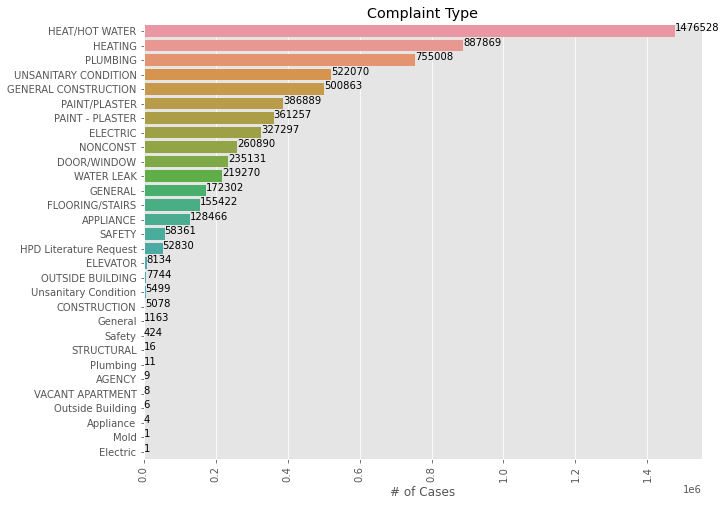

In [4]:
plt.figure(figsize=(10,8))
ax = sns.barplot(y=df['complaint_type'].value_counts().index,
            x=df['complaint_type'].value_counts().values, 
            data=df)
for rect in ax.patches:
    ax.text(rect.get_width(), rect.get_y()+rect.get_height()/2, '%d'%rect.get_width())
plt.xticks(rotation=90)
plt.xlabel('# of Cases')
plt.title('Complaint Type')
plt.show()

<p style='font-family:Trebuchet MS; color:#34459E'>Observation(s): <ol><p style='font-family:Trebuchet MS'>
1. Top complaint_type is HEAT/HOT WATER(1476528), followed by HEATING (887869), PLUMBING (755008), UNSANITARY CONDITION(522070) and GENERAL CONSTRUCTION(500863). Seems like we have answer to our Question 1 in Problem Statement. <br>
2. HEAT/HOT WATER is almost double of HEATING and both of them indicating the same problem - HEATING & HOT WATER issue.

<p style='font-family:Trebuchet MS'> General Trend of Top 5 <code>complaint_type</code> over the years. 

In [5]:
top_5 = [x for x in df['complaint_type'].value_counts().index[:5]]

In [6]:
x = pd.get_dummies(df['complaint_type'])
x = x[top_5]
ts = pd.concat([df['created_date'],x], axis=1)
ts= ts.set_index(['created_date']).resample('MS').sum()

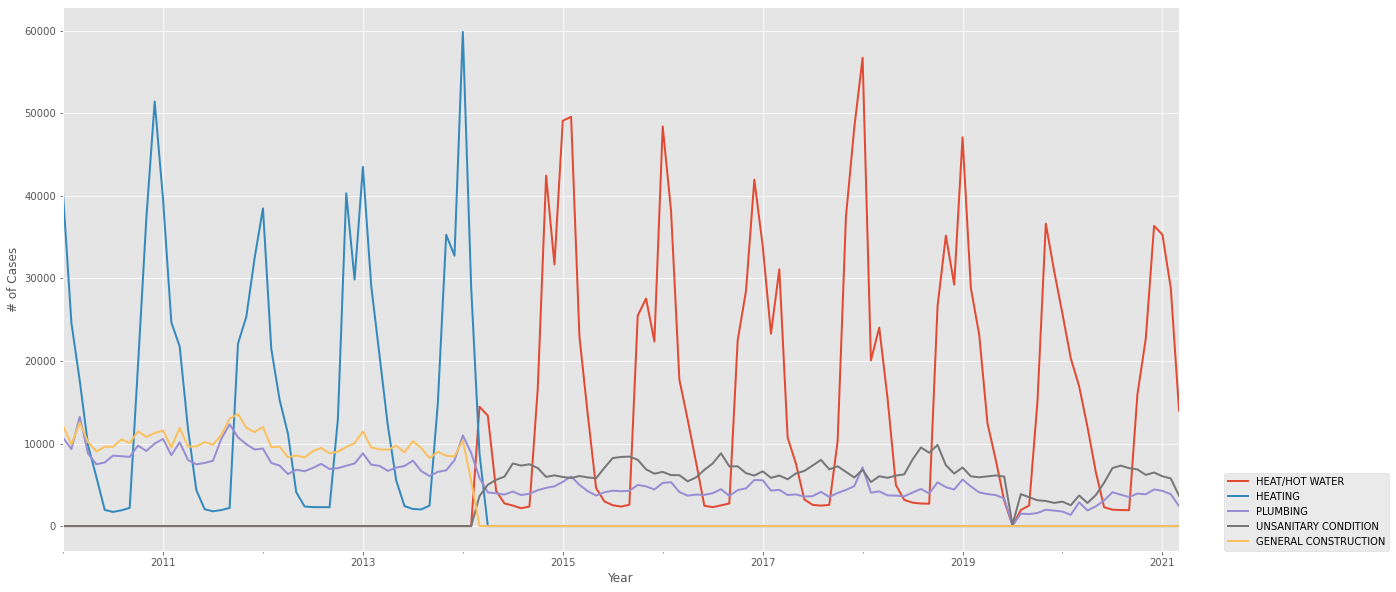

In [7]:
ts.plot(figsize=(20,10), linewidth=2)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.xlabel('Year')
plt.ylabel('# of Cases')
plt.show()

<p style='font-family:Trebuchet MS; color:#34459E'>Observation(s): 
<p style='font-family:Trebuchet MS; color:#FF4500'>HEAT/HOT WATER</p><p style='font-family:Trebuchet MS'>The Most Complaint Type since Year 2015. There are seasonality around the year. The # of cases spikes at the end of the years and continues to the beginning of the preceeding year and finally goes down in the middle of the year.
<p style='font-family:Trebuchet MS; color:#3498DB'>HEATING</p><p style='font-family:Trebuchet MS'>The previous most complaint type before HEAT/HOT WATER (from year 2010 to 2014). Having the similar pattern with HEAT/HOT WATER, it is probably replaced by HEAT/HOT WATER in the later years. 
<p style='font-family:Trebuchet MS; color:#8A2BE2'>PLUMBING</p><p style='font-family:Trebuchet MS'>Number of PLUMBING complaint cases remained constant in every month and eventually every year.
<p style='font-family:Trebuchet MS; color:#808080'>UNSANITARY CONDITION</p><p style='font-family:Trebuchet MS'>It first appeared in Year 2014. Since then, # of UNSANITARY CONDITION complaint cases remained constant monthly and annually.
<p style='font-family:Trebuchet MS; color:#FFD700'>GENERAL CONSTRUCTION</p><p style='font-family:Trebuchet MS'>The last record of complaint cases of GENERAL CONSTRUCTION stopped in the Year 2014. Before that, # of GENERAL CONSTRUCTION remained constant monthly and annually.

<h2 style='font-family:Trebuchet MS; color:#34459E'>Answer to Problem Statement 1:</h2>
<p style='font-family:Trebuchet MS'>Considering both the total amount of complaints made and the trend in recent years, Department of Housing Preservation and Development of New York City (HPD) should focus on <b>HEAT/HOT WATER</b>. <br> 
A quick research on Google can tell it has always been a concern for HPD.<br>
    To tackle this issue, HPD announced <b>"heat season"</b>, it begins October 1st every year continues to May 31st the preceeding year. During this season, all residential building owners are required to maintain indoor temperatures at 68 degrees when outdoor temperatures fall below 55 degrees during the day. Indoor temperatures must also be a minimum of 62 degrees overnight, regardless of outdoor temperatures. Building owners are legally required to provide hot water at 120 degrees year-round. Also, financial assistance for owner-occupied properties are also available. <br> More information can be found <a href= 'https://www1.nyc.gov/site/hpd/news/042-20/hpd-start-the-2020-2021-heat-season-new-york-city#/0'> here</a>.

<img src='https://www1.nyc.gov/assets/hpd/images/content/pr/2019/heat-season.jpg' align='middle'>

<h1 style='font-family:Trebuchet MS; color:#34495E'> Problem Statement 2<a id='4'></a></h1>
<p style='font-family:Trebuchet MS'>Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

In [8]:
df = df[df['complaint_type']=='HEAT/HOT WATER']

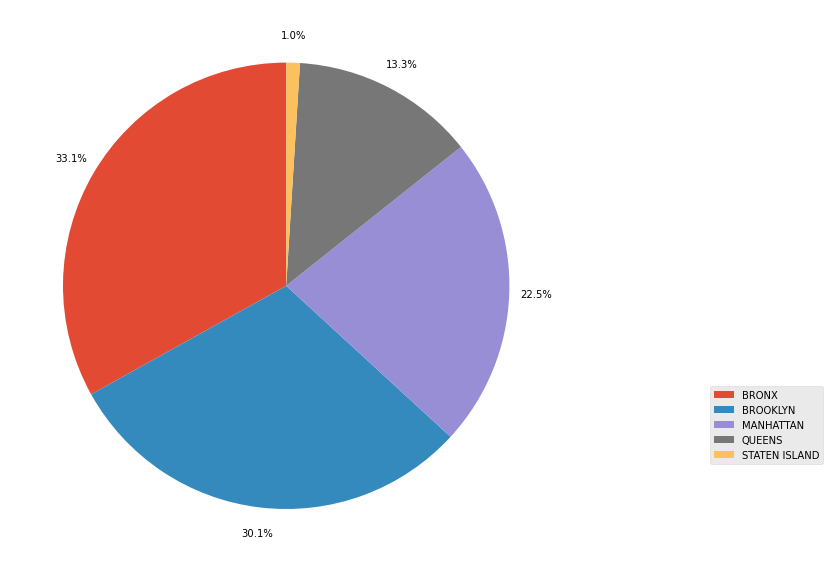

In [9]:
plt.figure(figsize=(10,12))
labels = df['borough'].value_counts().index[:5]
df['borough'].value_counts()[:5].plot(kind='pie',
                                  autopct='%1.1f%%',
                                  pctdistance = 1.12,
                                  labels= None,
                                  startangle=90)
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1.25,.25), ncol=1)
plt.ylabel('')
plt.show()

<p style='font-family:Trebuchet MS; color:#34459E'>Observation(s): </p>

<p style='font-family:Trebuchet MS'>The complaints are mostly come from BRONX(33.1%) and BROOKLYN(30.1%). It could be hard to choose among them on which to focus. However, if considering the populations of each borough as one of the criteria might give a better picture of the situation.  

<p style='font-family:Trebuchet MS'>Getting the information <a href='https://www.citypopulation.de/en/usa/newyorkcity/'> from U.S. Census Bureau </a>, as Estimate (2019-07-01), the populations of each borough are as follow:
<table style='font-family:Trebuchet MS'>
    <tr>
        <th>Borough</th>
        <th>Population</th>
    </tr>
    <tr>
        <td>Bronx</td>
        <td>1,418,207</td>   
    </tr>
    <tr>
        <td>Brooklyn</td>
        <td>2,559,903</td>   
    </tr>    
    <tr>
        <td>Manhattan</td>
        <td>1,628,706</td>   
    </tr>    
    <tr>
        <td>Queens</td>
        <td>2,253,858</td>   
    </tr>    
    <tr>
        <td>Staten Island</td>
        <td>476,143</td>   
    </tr>    

In [10]:
populations = pd.DataFrame({'Borough':['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'], 'Population':[1418207, 2559903, 1628706, 2253858, 476143]})
complaints = pd.DataFrame(df['borough'].value_counts()[:5]).reset_index().rename(columns={'borough':'Complaints', 'index':'Borough'})
complaint_populations = pd.concat([populations, complaints['Complaints']], axis=1)
complaint_populations['%complaints'] = round(complaint_populations['Complaints']*100/complaint_populations['Population'], 2)
complaint_populations.sort_values(['%complaints'], ascending=False).style.background_gradient()

,Borough,Population,Complaints,%complaints
0,BRONX,1418207,488445,34.440000
2,MANHATTAN,1628706,332437,20.410000
1,BROOKLYN,2559903,444313,17.360000
3,QUEENS,2253858,196771,8.730000
4,STATEN ISLAND,476143,14561,3.060000


<p style='font-family:Trebuchet MS; color:#34459E'>Observation(s): </p>
1. <code>% of complaints</code> in BRONX is the highest, followed by MANHATTAN. <br>
2. BROOKLYN although has the second highest complaint cases lodged, but due to its larger populations, it has the third % of complaints.

In [11]:
df = df[df['borough']=='BRONX']

In [12]:
df = df.dropna(axis=0)

In [13]:
df['incident_zip'] = df['incident_zip'].astype('int')
df['incident_zip'] = df['incident_zip'].astype('str')

In [14]:
df_zip = pd.DataFrame(df['incident_zip'].value_counts()).reset_index().rename(columns={'incident_zip': 'NumCases','index':'incident_zip'})

In [15]:
threshold_scale = np.linspace(df_zip['NumCases'].min(),
                              df_zip['NumCases'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 
fig = folium.Map(location=[40.8448, -73.8648], zoom_start=12)
fig.choropleth(geo_data = 'nyZips.geojson',
                data= df_zip,
                columns=['incident_zip','NumCases'],
                key_on = 'feature.properties.postalcode',
                fill_color = 'RdGy_r',
                threshold_scale = threshold_scale)
fig

<p style='font-family:Trebuchet MS; color:#34459E'>Observation(s): </p>
The complaints came from the west BRONX.

In [16]:
df_zip.head().style.background_gradient()

,incident_zip,NumCases
0,10458,45319
1,10467,44731
2,10468,40756
3,10453,39522
4,10457,37292


<h2 style='font-family:Trebuchet MS; color:#34459E'>Answer to Problem Statement 2:</h2>
<p style='font-family:Trebuchet MS'> Considering the amount of complaints & the ratio of complaints to population, the main focus here should be on <b>BRONX</b>. The western part(<b>10458, 10467, 10468, 10453, 10457</b>) of BRONX complaints more. 

<img src='http://www.bronxmall.com/com/reference/zipcode.jpg'/>

<h1 style='font-family:Trebuchet MS; color:#34495E'> Problem Statement 3<a id='5'></a></h1>
<p style='font-family:Trebuchet MS'>Does the Complaint Type that you identified in response to question 1 have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?

<p style='font-family:Trebuchet MS'>Dataset 1 does not indicates any building characteristics so another dataset, Dataset 2 is imported and then merged with Dataset 1.

<h1 style='font-family:Trebuchet MS; color:#34495E'> About Dataset 2<a id='6'></a></h1><p style='font-family:Trebuchet MS'>
This PLUTO dataset will have the housing characteristic in BRONX. It can be downloaded from <a href = ' https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1.zip'> here </a>.

<table style='font-family:Trebuchet MS'>
  <tr>
    <th>Field</th>
    <th>Description</th>
  </tr>
  <tr>
      <td><code>Address</code></td>
    <td>The building's address. </td>
  </tr>
  <tr>
    <td><code>BldgDepth</code></td>
    <td>The building’s depth, which is the effective perpendicular distance, measured in feet.</td>
  </tr>  
  <tr>
    <td><code>BuiltFAR</code></td>
    <td>The BUILT FLOOR AREA RATIO is the total building floor area divided by the area of the tax lot.</td>
  </tr>  
  <tr>
    <td><code>LotArea</code></td>
    <td>Total area of the tax lot, expressed in square feet rounded to the nearest integer.</td>
  </tr> 
    <tr>
    <td><code>LotDepth</code></td>
    <td>The tax lot's depth measured in feet.</td>
  </tr> 
    <tr>
    <td><code>NumFloors</code></td>
    <td>The number of full and partial stories starting from the ground floor, for the tallest building on the tax lot.</td>
  </tr>  
    <tr>
    <td><code>ResArea</code></td>
    <td>An estimate of the exterior dimensions of the portion of the structure(s) allocated for residential use. </td>
  </tr> 
    <tr>
    <td><code>YearBuilt</code></td>
    <td>The year construction of the building was completed. </td>
  </tr>
    <tr>
    <td><code>YearAlter1</code></td>
    <td>If a building has only been altered once, YEAR ALTERED 1 is the date that alteration began. </td>
  </tr>    
    <tr>
    <td><code>ZipCode</code></td>
    <td>The zip code that the tax lot is located in.Only one data source is used per tax lot.The zip code is obtained from the Department of City Planning Geosupport System. If the zip code is not available from Geosupport, the DOF-RPAD Master file is used. If a tax lot is split by a zip code boundary, only one zip code is retained..</td>
  </tr>    
    <tr>
    <td><code>YCoord</code></td>
    <td>The Y coordinate of the XY coordinate pair which depicts the approximate location of the lot. The XY coordinates are expressed in the New YorkLong Island State Plane coordinate system.</td>
  </tr>   
    <tr>
    <td><code>XCoord</code></td>
    <td>The X coordinate of the XY coordinate pair which depicts the approximate location of the lot. The XY coordinates are expressed in the New YorkLong Island State Plane coordinate system. </td>
  </tr>       
    
    
    
    
    
</table>

<p style='font-family:Trebuchet MS'> From Above Dataset 2 section, it is easy to see that the types of features can be categorised into: <ol><p style='font-family:Trebuchet MS'>
1. <code>BldgDepth, BuiltFAR, LotArea, LotDepth, ResArea</code>, <code>YearBuilt, YearAlter1, NumFloors</code> are numerical features.<br>
2. <code>ZipCode, YCoord, XCoord</code> are geospatial data.

In [17]:
dataset_2 = pd.read_csv('BX_18v1.csv')
dataset_2 = dataset_2[['Address', 'BldgDepth', 'BuiltFAR','LotArea', 'LotDepth', 'NumFloors', 'ResArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']]

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [18]:
dataset_2 = dataset_2.drop_duplicates()

In [19]:
dataset_2.dropna(subset=['Address'], axis=0, inplace=True)

In [20]:
dataset_1= pd.DataFrame(df['incident_address'].value_counts()).reset_index().rename(columns={'incident_address':'NumCases','index':'incident_address'})

In [21]:
df_ = pd.merge(left= dataset_2,
               right = dataset_1,
               left_on = 'Address',
               right_on = 'incident_address',
               how = 'left')
df_ = df_.replace(np.nan, 0)

<p style='font-family:Trebuchet MS'>NumCases distribution

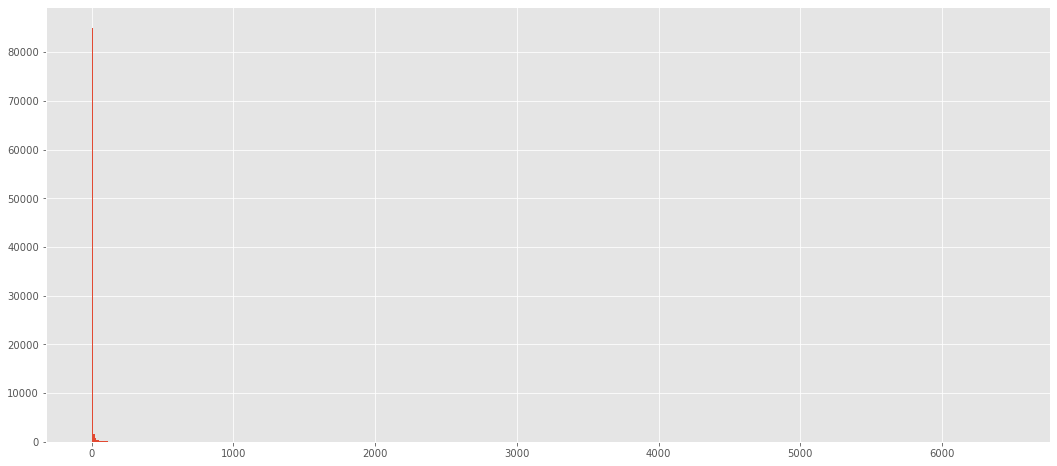

In [22]:
df_['NumCases'].hist(bins=600)
plt.show()

<p style='font-family:Trebuchet MS; color:#34495E'>Observation:<br>
    <p style='font-family:Trebuchet MS'>
     Noting though the bins of this histogram is set to 600, the histogram is still extremenly imbalance that most <code>address</code> contributed less than 10 complaints indicating only small portions of the <code>address</code> contributed more than 10 cases. So here, we will create a new column <code>Group</code> to categorise the <code>address</code> to more than 10 cases (1) or less than 10 cases (0). A 1 in <code>Group</code> would indicate the <code>address</code> has a higher tendency to lodge complaints in the future.

In [23]:
df_['group'] = [0 if x == 0 else 1 for x in df_['NumCases']]

<h2 style='font-family:Trebuchet MS; color:#34495E'> Feature Selection

<img src='https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png'>

<a href='https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/'> source </a>

<p style='font-family:Trebuchet MS'> From the above, we can see that for numerical input and categorical output, ANOVA & Kendall's are much better. Kendall's does assume that the categorical variable is ordinal so we would use ANOVA here. 

In [24]:
X = df_.iloc[:,1:11]  #independent columns
y = df_['group']    

bestfeatures = SelectKBest(score_func=f_classif, k=4)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)


featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))

        Specs         Score
4   NumFloors  16268.331519
1    BuiltFAR   7747.229792
0   BldgDepth   7070.922905
7  YearAlter1   1913.283509
5     ResArea    971.543020
6   YearBuilt    947.527349
9      YCoord    414.300266
8     ZipCode     45.007382
3    LotDepth      1.621426
2     LotArea      0.174753


<p style='font-family:Trebuchet MS; color:#34495E'>Observation:<br>
<p style='font-family:Trebuchet MS'> Interestingly, the anova (f_classif) gave similar results: <code>NumFloors(highest)</code>, <code>BuiltFAR, BldgDepth (second)</code>. Here, I chose the Top 3 variables only because the score between Top 3 and the others are extremely different; from 16419 to 0.15, this indicates that the Top 3 features are relatively important. Thus we will be using only the Top 3 variables as predictor variables to build our model.

<h2 style='font-family:Trebuchet MS; color:#34459E'>Answer to Problem Statement 3:</h2>
<p style='font-family:Trebuchet MS'> Considering the Score from f_classif(ANOVA), the building characteristics that have obvious relationship with the complaint type are <code>NumFloors(highest)</code>, <code>BuiltFAR, BldgDepth (second)</code>.

<h1 style='font-family:Trebuchet MS; color:#34495E'> Problem Statement 4<a id='7'></a></h1>
<p style='font-family:Trebuchet MS'> Can a predictive model be built for a future prediction of the number of complaints of the type that you have identified in response to question 1?

<p style='font-family:Trebuchet MS'>Using the predictor variables selected in feature selection, we build Decision Tree model for prediction. 

<p style='font-family:Trebuchet MS; color:#34495E'>Decision Tree<br>

In [25]:
X = df_[['NumFloors','LotDepth','BuiltFAR']]
X_ = X.values
y = df_['group'].values

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [27]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [28]:
yhat = tree.predict(x_test)

In [29]:
jaccard_score(y_test, yhat,pos_label=0)

0.8742071254964728

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 1056  1806]
 [  316 14747]]


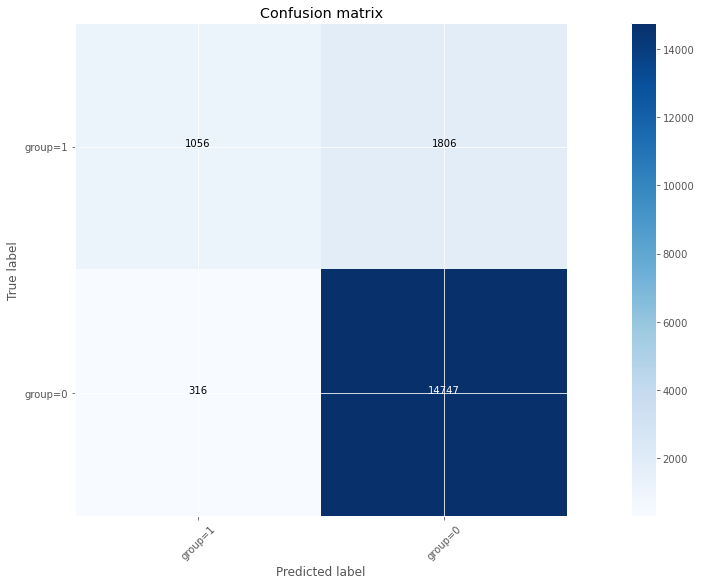

In [31]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['group=1','group=0'],normalize= False,  title='Confusion matrix')

In [32]:
yhat_prob = tree.predict_proba(x_test)
yhat_prob

array([[0.98, 0.02],
       [0.9 , 0.1 ],
       [0.93, 0.07],
       ...,
       [0.9 , 0.1 ],
       [0.93, 0.07],
       [0.18, 0.82]])

<p style='font-family:Trebuchet MS; color:#34495E'>Predict with some values<br>

In [33]:
pred = tree.predict([['0.0','88.0','1.8']])
prob = tree.predict_proba([['0.0','88.0','1.8']])
pred, prob

(array([0], dtype=int64), array([[0.71, 0.29]]))

<h2 style='font-family:Trebuchet MS; color:#34459E'>Answer to Problem Statement 4:</h2>
<p style='font-family:Trebuchet MS'> The model produces score of 0.86, which indicates that the model could predict relatively well. We also seemed to able to predict the possibility and probability of the complaint type with certain building characteristics given.

<h1 style='font-family:Trebuchet MS; color:#34495E'> TimeSeries Forecast <a id='8'></a></h1>
<p style='font-family:Trebuchet MS'> In addition to DecisionTree, time series forecating with fbProphet to predict the number of complaints in the future.

<p style='font-family:Trebuchet MS; color:#34495E'>Forecasting with fbProphet

In [34]:
df = df[['created_date', 'complaint_type']]
df = df.set_index(['created_date'])
df.index = pd.to_datetime(df.index)
df = df.resample('MS').count()

In [35]:
z = df
z = z.reset_index()
z.rename(columns={'created_date':'ds', 'complaint_type':'y'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


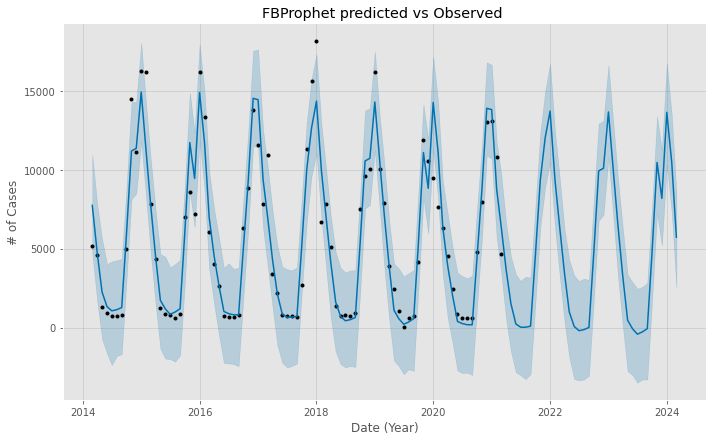

In [36]:
m = Prophet(interval_width=0.95)
m.fit(z)
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
m.plot(forecast)


plt.title('FBProphet predicted vs Observed ')
plt.xlabel('Date (Year)')
plt.ylabel('# of Cases')
plt.show()

<p style='font-family:Trebuchet MS; color:#34495E'>Observation:<br>

<p style='font-family:Trebuchet MS'>This model clearly captured monthly complaint cases seasonality. However, as the forecast further out into the future, it is natural that the values to become less accurate (eg. the value is decreasing below 0).

In [37]:
y_forecasted = forecast['yhat'][34:82]
y_truth = df['2017-01-01':]

print('RMSE = %.1f'  %np.sqrt(mean_squared_error(y_forecasted,  y_truth[:48])))

RMSE = 1626.5
